In [1]:
!pip install torchmetrics==0.6.2
!pip install transformers
!pip install plotly -U
!pip install pyyaml==5.4.1

In [2]:
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import numpy as np
import pandas as pd

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


In [3]:
from copy import deepcopy, copy

# Seed

In [258]:
SEED = 2222

gen_seed = torch.Generator().manual_seed(SEED)

# Model


In [168]:
%%writefile initializer.py

class initializer:
  def __init__(self, MODEL_NAME, **config):    
    self.MODEL_NAME = MODEL_NAME

    model = config.get("model")
    tokenizer = config.get("tokenizer")

    # print(model)
    self.model = model.from_pretrained(MODEL_NAME, 
                                       return_dict=True,
                                       output_attentions = False)
    self.tokenizer = tokenizer.from_pretrained(MODEL_NAME,
                                               do_lower_case = True)

Overwriting initializer.py


In [169]:
from initializer import initializer

a = {
    "model": BertModel,
    "tokenizer": BertTokenizer
     }

initializer_bert = initializer('bert-base-uncased', **a)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [170]:
class Encoder(nn.Module):
  def __init__(self, layers, freeze_bert):

    super(Encoder, self).__init__()
    # bert initializer
    self.model = deepcopy(initializer_bert.model)

    if freeze_bert:
      for param in self.model.parameters():
        param.requires_grad = freeze_bert

    old_model_encoder = self.model.encoder.layer
    new_model_encoder = nn.ModuleList()

    for i in layers:
      new_model_encoder.append(old_model_encoder[i])

    self.model.encoder.layer = new_model_encoder
  
  def forward(self, **x):
    return self.model(**x)


class SLR_Classifier(nn.Module):

  def __init__(self, **data):
    super(SLR_Classifier, self).__init__()
    self.dummy_param = nn.Parameter(torch.empty(0))
    
    self.Encoder = Encoder(layers = data.get("bert_layers",  range(12)),
                           freeze_bert = data.get("freeze_bert",  False))

    self.classifier = nn.Sequential(
            # nn.LayerNorm(self.Encoder.model.config.hidden_size),
            nn.Dropout(data.get("drop", 0.5)),
            nn.BatchNorm1d(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            nn.Linear(self.Encoder.model.config.hidden_size, 1),
            nn.Sigmoid(),
        )
    
    nn.init.normal_(self.classifier[2].weight, mean=0, std=0.00001)
    nn.init.zeros_(self.classifier[2].bias)

  def forward(self, **input):
    

    predict = self.Encoder(**input)
    predict = self.classifier(predict['pooler_output'])
    return predict.to(float)


In [171]:
torch.clear_autocast_cache()
torch.manual_seed(seed = SEED)

model = SLR_Classifier(bert_layers = range(2))

model
del model

# Datasets

In [275]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class SLR_DataSet(Dataset):

  def __init__(self, **args):
    
    self.tokenizer = args.get('tokenizer')
    self.data = args.get('data')
    self.max_token_len = args.get("max_token_len", 512)
    self.INPUT_NAME = args.get("input", 'x')
    self.LABEL_NAME = args.get("output", 'y')

    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row[self.INPUT_NAME]
    labels = data_row[self.LABEL_NAME]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.tensor([torch.tensor(labels).to(int)])
    )

In [276]:
DATA_path = '/content/SLRdata_cleaned_augmentation.csv'
test_DATA_path = '/content/SLR_NEW_forget_papers.csv'


SLR = pd.read_csv(DATA_path)
SLR_test = pd.read_csv(test_DATA_path)

SLR = SLR.drop('Unnamed: 0', axis=1)
SLR_test = SLR_test.drop('Unnamed: 0', axis=1)
SLR_test = SLR_test.rename(columns={'index': 'index_SLR'})

print(SLR['decision'].value_counts())
print('\n')
print(SLR['decision'].value_counts(normalize=True))
print('\n')

print('Total:' , SLR.shape)
SLR.sample(2)



0    47
1    28
Name: decision, dtype: int64


0    0.626667
1    0.373333
Name: decision, dtype: float64


Total: (75, 12)


,index_SLR,title,abstract,text,decision,text2,text3,text4,text5,text6,text7,text8
30,80,Artificial intelligence-based control for torq...,"In this research paper, a control mechanism pr...",Artificial intelligence-based control for torq...,0,"In this research paper, a control mechanism pr...",Artificial intelligence-based control for torq...,The problem is to find optimal values of scal...,Artificial intelligence-based control for torq...,meta-heuristic control scheme proposed to obta...,"in this research paper, a dynamic control mech...","in this research paper, a control mechanism pr..."
70,16,Optimization of Decision-Making in Artificial ...,The paper describes a new approach to the mode...,Optimization of Decision-Making in Artificial ...,0,The paper describes a new approach to the mode...,Optimization of Decision-Making in Artificial ...,"In this process of optimization, emphasis is ...",Optimization of Decision-Making in Artificial ...,the paper describes a new approach to the mode...,the paper mainly describes a new approach to w...,the paper describes a new approach to the mode...


## EDA

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



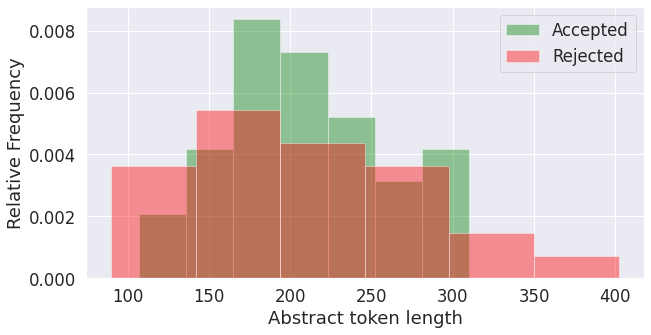

In [277]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.concat([SLR_test, SLR]).reset_index()
data.decision = data.decision.replace({0: 'Rejected',
                   1: 'Accepted'})


data.abstract = data['abstract'].map(lambda x: len(initializer_bert.tokenizer.encode(x)) )
splited_data = list(data.groupby('decision'))


# Increase the plot size and font size.
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

sns.distplot(splited_data[0][1].abstract,
             color='green',
             kde=False,
             norm_hist=True,
              rug=False,
              label = splited_data[0][0])

sns.distplot(splited_data[1][1].abstract,
             color = 'red',
             kde=False,
             rug=False,
             norm_hist=True,
             label = splited_data[1][0])

plt.xlabel('Abstract token length')
plt.ylabel('Relative Frequency')
plt.legend(loc='upper right')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0, 0.5, 'Relative Frequency')

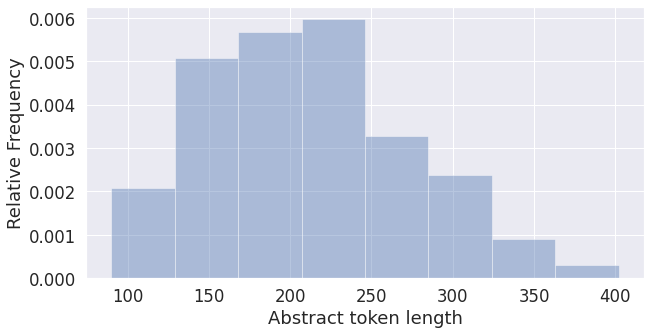

In [278]:
# Increase the plot size and font size.
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

sns.distplot(data.abstract,
            #  color='green',
             kde=False,
             norm_hist=True,
              rug=False)

plt.xlabel('Abstract token length')
plt.ylabel('Relative Frequency')


## spliting the data

### Utils

Function to automatization

In [279]:
from sklearn.model_selection import train_test_split


class augmatation_data_context():
  oringin_columns = [
                'decision',  # label
               'index_SLR', # text id
               'abstract',  # original input
               ]

  def __init__(self, **info):
    self.SLR = info.get('Data')
    self.main_input = info.get('main_input', 'text')
    self.augmatation_columns = info.get('augmatation_columns', [
              #  'text',
              # 'abstract',
               'text2',
               'text3',
               'text4',
               'text5',
               'text6',
               'text7',
               'text8'
               ])
    
   
    if 'abstract' in self.augmatation_columns:
      have_abstract = True
      self.augmatation_columns.remove('abstract')
    else:
      have_abstract = False

    columns = self.augmatation_columns + self.oringin_columns
    # print(columns)

    SLR_augmentation = self.SLR.loc[:, columns].copy()

    if have_abstract:
      SLR_augmentation['abstract_input'] = SLR_augmentation['abstract']
  
    self.SLR_augmentation = pd.melt(SLR_augmentation,
                                    id_vars=['decision', 'index_SLR','abstract'],
                                    value_name='text_input')

  @property
  def values_count(self):
    print('Augmatation propertys \n')
    print(self.SLR_augmentation.decision.value_counts())
    print(self.SLR_augmentation.groupby('variable').decision.value_counts())

  def sample(self, value, SEED=1, verbose = True):
    """value is total of samples for each decision"""
    SLR_augmentation = self.SLR_augmentation.groupby(['decision', 'variable']) \
                          .sample(frac=value, random_state = SEED, replace=False)
    SLR = self.SLR.copy()
    
    SLR['variable'] = self.main_input
    SLR.rename(columns={self.main_input: 'text_input'}, inplace=True)

    Data = pd.concat([
                SLR_augmentation,
                SLR 
                ],
                axis = 0)


    self.Data = Data.dropna(1).drop_duplicates(subset='text_input')

    # self.Data.rename(columns={self.main_input: 'text_input'}, inplace=True)

    # print(SLR_augmentation.groupby('variable').decision.value_counts())
    if verbose:
      print('\n The Data augmentation have:')
      print(self.Data.groupby('variable').decision.value_counts())

  @staticmethod
  def _split(Data,input_name = 'abstract',train_size=0.6, validation_size=0.7, SEED = 1, verbose = True):

    train_Data, cross_Data  = train_test_split(Data,
                                              stratify = Data['decision'],
                                              train_size=train_size,
                                              random_state= SEED,
                                              shuffle=True)

    valid_Data, test_Data  = train_test_split(cross_Data,
                                              stratify = cross_Data['decision'],
                                              train_size=validation_size,
                                              random_state= SEED,
                                              shuffle=True)

    if verbose:
      print('TRAIN SUMMARY:')
      print('\n')
      print(train_Data['decision'].value_counts())
      print('\n')
      print(train_Data[input_name].apply(lambda x: len(x.split(' '))).plot(kind = 'hist', title= '# of words'))

    return train_Data, valid_Data, test_Data

  def split(self, train_size=0.6, validation_size=0.7, SEED = 1, verbose = True):

    train_Data, cross_Data  = train_test_split(self.SLR,
                                              stratify = self.SLR['decision'],
                                              train_size=train_size,
                                              random_state= SEED,
                                              shuffle=True)

    valid_Data, test_Data  = train_test_split(cross_Data,
                                              stratify = cross_Data['decision'],
                                              train_size=validation_size,
                                              random_state= SEED,
                                              shuffle=True)
    
    train_Data = self.Data[self.Data['index_SLR'].isin(train_Data.index_SLR.values)]
    
    train_Data = train_Data.sample(frac=1, random_state = SEED).drop_duplicates(subset='text_input')


    if verbose:
      print('TRAIN SUMMARY:')
      print('\n')
      print(train_Data['decision'].value_counts())
      print('\n')
      print(train_Data.groupby('variable').decision.value_counts())
      print('\n')
      print(train_Data['text_input'].apply(lambda x: len(x.split(' '))).plot(kind = 'hist', title= '# of words'))

    return train_Data, valid_Data, test_Data

  @staticmethod
  def process(train_info = None,
              train_SAMPLER = True,
              valid_info = None,
              test_info= None,
              gen_seed = torch.Generator().manual_seed(1),
              drop_last= True):
    
    train = valid = test = None
    
    if train_info:
      if train_SAMPLER:
        train = data_transform(sampler(train_info['data'], gen_seed),
                       **train_info, drop_last =drop_last)
      else:
        train = data_transform(**train_info, drop_last =drop_last)

    if valid_info:
      valid = data_transform(**valid_info, drop_last =drop_last)

    if test_info:
      test = data_transform(**test_info, drop_last =drop_last)

    return (train, valid, test)

In [280]:
from torch.utils.data import WeightedRandomSampler
from collections import Counter 


def sampler(data, gen_seed):
  count = Counter(data['decision'])
  class_count = np.array([count[0],count[1]])
  class_weights =  1./class_count

  sample_weights =  np.array([class_weights[t] for t in data['decision']])
  sampler = WeightedRandomSampler(sample_weights,
                                len(sample_weights),
                                replacement=True,
                                generator=gen_seed)
  
  return sampler


def data_transform(sampler = None, drop_last = False, **info):
  data_set = SLR_DataSet(**info)
  
  data_loader = DataLoader(data_set,
                           sampler=sampler,
                           batch_size = info.get('batch_size', 1),
                           drop_last = drop_last
                           )
  return data_loader


### Augmentation Split

In [281]:
SLR['decision'].value_counts()

0    47
1    28
Name: decision, dtype: int64

In [282]:
META_INFO = {
    # DATA
             'Data': SLR,
             'main_input': 'text',
             'augmatation_columns':[
               'abstract',
              #  'text',
               'text2',
              #  'text3',
               'text4',
              #  'text5',
              #  'text6',
              #  'text7',
              #  'text8'
               ],
             'sample_augmatation': .20,
             'train_split_size': 0.7,
             'valid_split_size': 0.55,
             'batch_size_train':16,
             'max_token_len':312,
             'Oversampler': True,
    # LEARNER
             'N_EPOCH': 3,
             'LEARNING_RATE': 0.00006,
             'warmup_steps_pinnacle': 3,
    # MODEL
             'bert_layers': range(12),
             'drop': 0.05,
             'DECISION_BOUDERY': 0.5,
             'clip_gradient': 2,
    # EVALUATION
             'threshold':0.5
             }

augmatation_data = augmatation_data_context(**META_INFO)

# augmatation_data.values_count

In [283]:
augmatation_data.sample(META_INFO['sample_augmatation'], SEED=SEED)


 The Data augmentation have:
variable        decision
abstract_input  0            9
                1            6
text            0           47
                1           28
text2           0            9
                1            6
text4           0            9
                1            6
Name: decision, dtype: int64


TRAIN SUMMARY:


0    57
1    32
Name: decision, dtype: int64


variable        decision
abstract_input  0            9
                1            4
text            0           33
                1           19
text2           0            7
                1            4
text4           0            8
                1            5
Name: decision, dtype: int64


AxesSubplot(0.125,0.125;0.775x0.755)


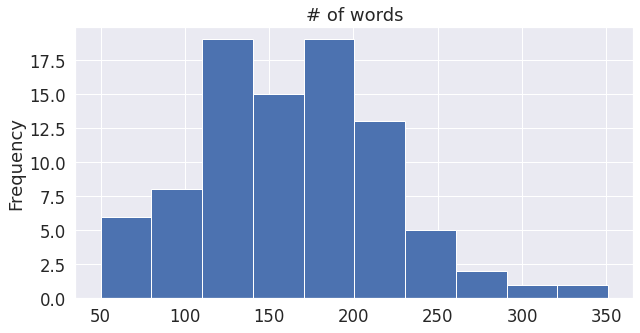

In [284]:
train_Data, valid_Data, test_Data = augmatation_data.split(train_size=META_INFO['train_split_size'],
                                                           validation_size=META_INFO['valid_split_size'], SEED = SEED)

In [285]:
test_Data.decision.value_counts()

0    7
1    4
Name: decision, dtype: int64

In [286]:
sample_by = int(SLR_test.decision.value_counts()[0]/2)

In [287]:
index_sample =  SLR_test.groupby('decision').sample(sample_by, random_state=SEED,
                                                    replace=False).index_SLR

data_partition_one = SLR_test[SLR_test.index_SLR.isin(index_sample)]
data_partition_two = SLR_test[~SLR_test.index_SLR.isin(index_sample)]

test_Data = pd.concat([data_partition_one,test_Data ]).dropna(1).sample(frac=1, random_state = SEED)

valid_Data = pd.concat([data_partition_two, valid_Data ]).dropna(1).sample(frac=1, random_state = SEED)



In [288]:
train_info = {
    'data': train_Data,
    'tokenizer': initializer_bert.tokenizer,
    'max_token_len': META_INFO['max_token_len'],
    'input': 'text_input',
    'output': 'decision',
    'batch_size':META_INFO['batch_size_train'], 
    }

valid_info = {
    'data': valid_Data,
    'tokenizer': initializer_bert.tokenizer,
    'max_token_len': META_INFO['max_token_len'],
    'input': 'abstract',
    'output': 'decision',
    'batch_size':len(valid_Data),
    }

test_info = {
    'data': test_Data,
    'tokenizer': initializer_bert.tokenizer,
    'max_token_len': META_INFO['max_token_len'],
    'input': 'abstract',
    'output': 'decision',
    'batch_size':len(test_Data),
    }

train, valid, test = augmatation_data_context.process(
    train_info = train_info,
    train_SAMPLER = META_INFO['Oversampler'],
    valid_info = valid_info,
    test_info = test_info,
    gen_seed = gen_seed,
    drop_last= True)

# Metrics

In [172]:
# from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.python.keras.metrics import SensitivitySpecificityBase

class WorkSavedOverSamplingAtRecall(SensitivitySpecificityBase):
    """
    Work saved over sampling at %recall metric
    """

    def __init__(self, recall, num_thresholds=200, name="wss_at_recall", dtype=None):
        if recall < 0 or recall > 1:
            raise ValueError('`recall` must be in the range [0, 1].')
        self.recall = recall
        self.num_thresholds = num_thresholds
        super(WorkSavedOverSamplingAtRecall, self).__init__(
            value=recall, num_thresholds=self.num_thresholds, name=name, dtype=dtype
        )

    def result(self):
        recalls = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_negatives
        )
        n = self.true_negatives + self.true_positives + self.false_negatives + self.false_positives
        wss = tf.math.divide_no_nan(
            self.true_negatives + self.false_negatives, n
        )
        return self._find_max_under_constraint(
            recalls, wss, tf.math.greater_equal
        )

    def get_config(self):
        """For serialization purposes"""
        config = {'num_thresholds': self.num_thresholds, 'recall': self.recall}
        base_config = super(WorkSavedOverSamplingAtRecall, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [173]:
from IPython.display import clear_output 

class table:
  data = []
  index = []

  @torch.no_grad()
  def __init__(self, data, epoch, name):
    self.index.append((epoch, name))
    self.data.append(data)


  @classmethod
  @torch.no_grad()
  def data_frame(cls):
    clear_output()
    index = pd.MultiIndex.from_tuples(cls.index, names=["Epoch", "Data"])
    data = pd.DataFrame(cls.data,  index=index)
    return data

  @classmethod
  @torch.no_grad()
  def reset(cls):
    cls.data = []
    cls.index = []

In [174]:
import torchmetrics
from torchmetrics import functional as fn
from torchmetrics import ConfusionMatrix
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
from pprint import pprint

class metrics():
  wss95 = WorkSavedOverSamplingAtRecall(recall=0.95, name='wss_95')
  wss = WorkSavedOverSamplingAtRecall(recall=1, name='wss')

  @classmethod
  @torch.no_grad()
  def work(cls, y_true, y_pred, loss = None, DECISION_BOUDERY = .5):
    y_true = y_true.to(int)

    cls.wss95.reset_state()
    cls.wss95.update_state(y_true, y_pred)
    
    cls.wss.reset_state()
    cls.wss.update_state(y_true, y_pred)
    
    y_pred = (y_pred > DECISION_BOUDERY).to(int)

    data = {
        "wss95": cls.wss95.result().numpy(),
        "wss": cls.wss.result().numpy(),
        'acc': fn.accuracy(y_pred, y_true).item(),
        'recall': fn.recall(y_pred, y_true).item(),
        'f1':fn.f1(y_pred, y_true).item()
            }

    if loss:
      data['loss'] = loss.item()

    return data

  @staticmethod
  def plot(data, label):
    # data.columns
    data = data.reset_index(level=[0,1], inplace=False)
    data['acc'] =data['acc'].astype(float) 
    return px.line(data_frame=data.round(4),
              x = 'Epoch',
              y = label,
              markers = True, 
              hover_data = data.columns,
              color = 'Data')

  @classmethod
  def multi_plot(cls, data, labels):
    n_plots = len(labels)
    n_lines = len(data.index.unique('Data'))

    fig = make_subplots(rows=n_plots,
                        cols=1,
                        subplot_titles = labels)

    for row in range(1, n_plots+1):
      label = labels[row - 1]
      lines = cls.plot(data, label)

      for line in list(lines.select_traces()):
        if row  > 1:
          line.showlegend = False
        fig.add_trace(line,
                      row = row,
                      col = 1)
      
    fig.update_xaxes(title_text = 'Epoch',
                       row = row,
                       col = 1)
    return fig

  @staticmethod
  @torch.no_grad()
  def get_confusion_matrix(model, data_loader, num_classes = 2, threshold = .5, verbose = True):
    model.eval()

    confmat = ConfusionMatrix(num_classes=num_classes, threshold = threshold)

    _ , y, predict = loop.test_one_epoch(model, data_loader)
    
    metrics_values =  metrics.work(y, predict)
   
    if verbose:
      print(pd.DataFrame({'y': y.numpy(),
                    'predict': predict.numpy(),
                    }))
      print('\n Metrics values')
      pprint(metrics_values)

    cm = confmat(predict.cpu(), y.to(int).cpu()).numpy()

    if verbose:
      group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
      group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
      
      labelz = [f"{v1}<br>{v2}" for v1, v2 in zip(group_counts, group_percentages)]
      labelz = np.asarray(labelz).reshape(2,2)
      
      fig = px.imshow(cm/np.sum(cm),
                      x = ['0','1'],
                      y = ['0','1'],
                      text_auto=True,
                      color_continuous_scale='Blues',
                      aspect="auto",
                      zmin = 0
                      )
      
      fig.update_traces(text=labelz, texttemplate = "%{text}")
      fig.update_layout(yaxis={"title": 'Label'},
                        xaxis={"title": 'Predict'})
      
      fig.update_xaxes(title_font=dict(size=20, color = 'black'),
                       tickfont=dict(size=20))
      fig.update_yaxes(title_font=dict(size=20, color = 'black'),
                       tickfont=dict(size=20))
      fig.show()

    metrics_values['Confusion_matrix'] = [cm.tolist()]

    return metrics_values

In [175]:
class loop():

  @classmethod
  def train_one_epoch(cls, model, data_loader, loss_fn, optimizer, scheduler = None, clip_gradient = None):
    all_y = []
    all_predict = []
    total_loss = 0
    model.train()
    device = model.dummy_param.device

    for batch_step, batch in enumerate(data_loader):
      batch_input = batch.copy()

      (loss, y, predict) = cls.train_one_step(model, batch, optimizer, device, loss_fn, scheduler, clip_gradient = clip_gradient)
      
      with torch.no_grad():
        all_y.append(y)
        all_predict.append(predict.detach())
        total_loss += loss
    
    mean_loss = total_loss/(batch_step+1)

    return (mean_loss,
            torch.cat(all_y).squeeze(),
            torch.cat(all_predict).squeeze() )

  @staticmethod
  def train_one_step(model, batch, optimizer, device, loss_fn, scheduler = None, clip_gradient = None):
    # device = model.dummy_param.device
    optimizer.zero_grad()

    input = {k:v.to(device = device) for k, v in batch.items()}
    y = input.pop('labels').to(float)

    predict = model(**input)

    loss = loss_fn(predict , y)
    loss.backward()

    if clip_gradient:
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_gradient)
    
    optimizer.step()

    if scheduler:
      scheduler.step()

    return loss.cpu(), y.cpu(), predict.cpu()

  @classmethod
  def valid_one_epoch(cls, model, data_loader, loss_fn):
    all_y = []
    all_predict = []
    total_loss = 0
    batch_step = 0
    model.eval()
    device = model.dummy_param.device
    
    for batch_step, batch in enumerate(data_loader):
      batch_input = batch.copy()

      (loss, y, predict) = cls.valid_one_step(model, batch, device, loss_fn)
      
      with torch.no_grad():
        all_y.append(y)
        all_predict.append(predict.detach())
        total_loss += loss
    
    mean_loss = total_loss/(batch_step+1)

    return (mean_loss,
            torch.cat(all_y).squeeze(),
            torch.cat(all_predict).squeeze() )

  @staticmethod
  def valid_one_step(model, batch, device, loss_fn):
    # device = model.dummy_param.device

    input = {k:v.to(device = device) for k, v in batch.items()}
    y = input.pop('labels').to(float)

    predict = model(**input)

    loss = loss_fn(predict , y)

    return loss.cpu(), y.cpu(), predict.cpu()

  @classmethod
  def test_one_epoch(cls, model, data_loader, loss_fn = None):
    all_y = []
    all_predict = []
    total_loss = 0
    model.eval()
    device = model.dummy_param.device
    
    for batch_step, batch in enumerate(data_loader):
      batch_input = batch.copy()

      (loss, y, predict) = cls.test_one_step(model, batch,device, loss_fn )
      
      with torch.no_grad():
        all_y.append(y)
        all_predict.append(predict.detach())
        total_loss += loss
    
    mean_loss = total_loss/(batch_step+1)

    return (mean_loss,
            torch.cat(all_y).squeeze(),
            torch.cat(all_predict).squeeze() )

  @staticmethod
  def test_one_step(model, batch,device, loss_fn = None ):
    # device = model.dummy_param.device

    input = {k:v.to(device = device) for k, v in batch.items()}
    y = input.pop('labels').to(float)

    predict = model(**input)

    if loss_fn:
      loss = loss_fn(predict , y)
      return loss.cpu(), y.cpu(), predict.cpu()
    else:
      return 0, y.cpu(), predict.cpu()

# Learning

In [289]:
import torch
from torch import nn
import os
import numpy as np
import random
import gc

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)
random.seed(SEED)
torch.clear_autocast_cache()
torch.manual_seed(SEED)
gc.collect()
torch.cuda.empty_cache()


Learning = {'N_EPOCH': META_INFO['N_EPOCH'],
            'BATCH_SIZE': train_info.get('batch_size'),
            'LEARNING_RATE': META_INFO['LEARNING_RATE']
            }

steps_per_epoch=len(train_Data) // Learning.get('BATCH_SIZE')
total_training_steps = steps_per_epoch * Learning.get('N_EPOCH')

warmup_steps = total_training_steps // META_INFO['warmup_steps_pinnacle']
print("warmup_steps, total_training_steps: ", warmup_steps, total_training_steps)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SLR_Classifier(**{
"bert_layers": META_INFO['bert_layers'],
'drop': META_INFO['drop']
}).to(device)


loss_fn =  nn.BCELoss(reduction = 'mean')
optimizer = AdamW(model.parameters(), lr=Learning.get('LEARNING_RATE'))
scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)



Epochs = Learning.get('N_EPOCH')
DECISION_BOUDERY = META_INFO['DECISION_BOUDERY']

table.reset()

# THE MAIN TRAINING LOOOP
for Epoch in range(0, Epochs):
  model.train()
  loss, y , y_ = loop.train_one_epoch(model, train, loss_fn, optimizer, scheduler, clip_gradient=META_INFO['clip_gradient'])
  
  if Epoch%1 == 0:
    res = metrics.work(y,
                       y_,
                       loss,
                       DECISION_BOUDERY)
    
    table(res, Epoch, 'Train')

    with torch.no_grad():
      model.eval()
      loss, y , y_ = loop.valid_one_epoch(model, valid, loss_fn)

      res = metrics.work(y,
                        y_,
                        loss,
                         DECISION_BOUDERY)

      table(res, Epoch, 'Valid')
    print(table.data_frame().round(2))


del optimizer, scheduler, loss_fn
del loss, y, y_
torch.cuda.empty_cache()

             wss95   wss   acc  recall    f1  loss
Epoch Data                                        
0     Train   0.04  0.00  0.60    0.60  0.60  0.69
      Valid   0.00  0.00  0.47    0.47  0.47  0.69
1     Train   0.11  0.06  0.74    0.74  0.74  0.68
      Valid   0.18  0.18  0.53    0.53  0.53  0.69
2     Train   0.26  0.21  0.76    0.76  0.76  0.66
      Valid   0.18  0.18  0.65    0.65  0.65  0.68


In [290]:
metrics.multi_plot(table.data_frame() ,['loss', 'acc'])

# EVALUATION MODEL

In [291]:
TEST_RESULTS = []
VALID_RESULTS = []

## Evaluation

In [292]:
result = metrics.get_confusion_matrix(model, test, threshold=META_INFO['threshold'])

TEST_RESULTS.append((SEED, result))

      y   predict
0   0.0  0.538834
1   1.0  0.534328
2   1.0  0.472509
3   1.0  0.478147
4   0.0  0.474041
5   0.0  0.478986
6   0.0  0.507118
7   1.0  0.539953
8   0.0  0.506370
9   1.0  0.508214
10  0.0  0.532180
11  0.0  0.533954
12  0.0  0.495446
13  0.0  0.531489
14  1.0  0.537580
15  1.0  0.525257
16  0.0  0.526454

 Metrics values
{'acc': 0.47058823704719543,
 'f1': 0.47058823704719543,
 'recall': 0.47058823704719543,
 'wss': 0.0,
 'wss95': 0.0}


In [293]:
result = metrics.get_confusion_matrix(model, valid)

VALID_RESULTS.append((SEED, result))

      y   predict
0   0.0  0.522824
1   0.0  0.471069
2   0.0  0.534947
3   1.0  0.518254
4   0.0  0.458212
5   0.0  0.460986
6   1.0  0.536530
7   1.0  0.485146
8   1.0  0.519249
9   0.0  0.499740
10  0.0  0.534292
11  0.0  0.487498
12  1.0  0.471537
13  0.0  0.458776
14  1.0  0.523989
15  0.0  0.502244
16  1.0  0.530533

 Metrics values
{'acc': 0.6470588445663452,
 'f1': 0.6470588445663452,
 'recall': 0.6470588445663452,
 'wss': 0.1764706,
 'wss95': 0.1764706}


## SEEDs

In [294]:
SEEDS = [2022, 2202, 2220, 222]
# np.random.seed(10)
# SEEDS = np.random.choice(range(2221), 15, replace=False).tolist()

### TESTING Seeds

In [295]:
for SEED in SEEDS:

  # DATA
  gen_seed = torch.Generator().manual_seed(SEED)

  First_test = augmatation_data_context(**META_INFO)

  # First_test.values_count

  First_test.sample(META_INFO['sample_augmatation'], SEED=SEED, verbose=False)

  train_Data, valid_Data, test_Data = First_test.split(train_size=META_INFO['train_split_size'],
                                        validation_size=META_INFO['valid_split_size'],
                                        SEED = SEED, verbose=False)
  
  index_sample =  SLR_test.groupby('decision').sample(sample_by, random_state=SEED,
                                                    replace=False).index_SLR

  data_partition_one = SLR_test[SLR_test.index_SLR.isin(index_sample)]
  data_partition_two = SLR_test[~SLR_test.index_SLR.isin(index_sample)]

  test_Data = pd.concat([data_partition_one,test_Data ]).dropna(1).sample(frac=1, random_state = SEED)

  valid_Data = pd.concat([data_partition_two, valid_Data ]).dropna(1).sample(frac=1, random_state = SEED)


  train_info = {
      'data': train_Data,
      'tokenizer': initializer_bert.tokenizer,
      'max_token_len': META_INFO['max_token_len'],
      'input': 'text_input',
      'output': 'decision',
      'batch_size':META_INFO['batch_size_train'], 
      }

  valid_info = {
      'data': valid_Data,
      'tokenizer': initializer_bert.tokenizer,
      'max_token_len': META_INFO['max_token_len'],
      'input': 'abstract',
      'output': 'decision',
      'batch_size':len(valid_Data),
      }

  test_info = {
      'data': test_Data,
      'tokenizer': initializer_bert.tokenizer,
      'max_token_len': META_INFO['max_token_len'],
      'input': 'abstract',
      'output': 'decision',
      'batch_size':len(test_Data),
      }

  train, valid, test = augmatation_data_context.process(
      train_info = train_info,
      train_SAMPLER = META_INFO['Oversampler'],
      valid_info = valid_info,
      test_info = test_info,
      gen_seed = gen_seed,
      drop_last= True)

  ## TRAINING

  import torch
  from torch import nn
  import os
  import numpy as np
  import random
  import gc

  torch.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  torch.backends.cudnn.deterministic = True
  np.random.seed(SEED)
  random.seed(SEED)
  torch.clear_autocast_cache()
  torch.manual_seed(SEED)
  gc.collect()
  torch.cuda.empty_cache()


  Learning = {'N_EPOCH': META_INFO['N_EPOCH'],
              'BATCH_SIZE': train_info.get('batch_size'),
              'LEARNING_RATE': META_INFO['LEARNING_RATE']
              }

  steps_per_epoch=len(train_Data) // Learning.get('BATCH_SIZE')
  total_training_steps = steps_per_epoch * Learning.get('N_EPOCH')

  warmup_steps = total_training_steps // META_INFO['warmup_steps_pinnacle']

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = SLR_Classifier(**{
  "bert_layers": META_INFO['bert_layers'],
  'drop': META_INFO['drop']
  }).to(device)



  loss_fn =  nn.BCELoss(reduction = 'mean')
  optimizer = AdamW(model.parameters(), lr=Learning.get('LEARNING_RATE'))
  scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
  )



  Epochs = Learning.get('N_EPOCH')
  DECISION_BOUDERY = META_INFO['DECISION_BOUDERY']

  # table.reset()

  # THE MAIN TRAINING LOOOP
  for Epoch in range(0, Epochs):
    model.train()
    loss, y , y_ = loop.train_one_epoch(model, train, loss_fn, optimizer, scheduler, clip_gradient=META_INFO['clip_gradient'])

  del optimizer, scheduler, loss_fn
  del loss, y, y_
  torch.cuda.empty_cache()


  ## EVALUATING

  result = metrics.get_confusion_matrix(model, test, threshold=META_INFO['threshold'], verbose = False)

  TEST_RESULTS.append((SEED, result))

  result = metrics.get_confusion_matrix(model, valid, verbose = False)

  VALID_RESULTS.append((SEED, result))

## RESULT

In [296]:
indexs = [seed for seed, resuts in TEST_RESULTS]

# Confusion_matrix = [[TN, FN], [FP, TP]]

TEST_RESULTS_data = [resuts for seed, resuts in TEST_RESULTS]
TEST_RESULTS_data = pd.DataFrame(TEST_RESULTS_data, index= indexs)

VALID_RESULTS_data = [resuts for seed, resuts in VALID_RESULTS]
VALID_RESULTS_data = pd.DataFrame(VALID_RESULTS_data, index= indexs)


In [297]:
TEST_RESULTS_data.loc[:, TEST_RESULTS_data.columns != 'Confusion_matrix'].describe()

,wss95,wss,acc,recall,f1
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.094118,0.094118,0.529412,0.529412,0.529412
std,0.067069,0.067069,0.072044,0.072044,0.072044
min,0.000000,0.000000,0.470588,0.470588,0.470588
25%,0.058824,0.058824,0.470588,0.470588,0.470588
50%,0.117647,0.117647,0.529412,0.529412,0.529412
75%,0.117647,0.117647,0.529412,0.529412,0.529412
max,0.176471,0.176471,0.647059,0.647059,0.647059


In [298]:
VALID_RESULTS_data.loc[:, TEST_RESULTS_data.columns != 'Confusion_matrix'].describe()

,wss95,wss,acc,recall,f1
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.082353,0.082353,0.611765,0.611765,0.611765
std,0.114668,0.114668,0.114668,0.114668,0.114668
min,0.000000,0.000000,0.411765,0.411765,0.411765
25%,0.000000,0.000000,0.647059,0.647059,0.647059
50%,0.000000,0.000000,0.647059,0.647059,0.647059
75%,0.176471,0.176471,0.647059,0.647059,0.647059
max,0.235294,0.235294,0.705882,0.705882,0.705882


# Training tests


## STANDART TEST

### SPLIT DATA

TRAIN SUMMARY:


0    23
1    14
Name: decision, dtype: int64


AxesSubplot(0.125,0.125;0.775x0.755)


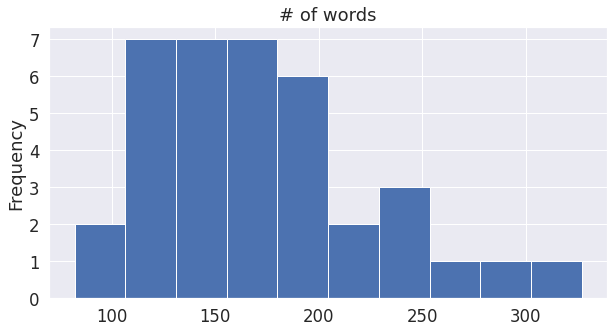

In [37]:
SEED = 1
train_Data, valid_Data, test_Data = augmatation_data_context._split(SLR,
                                                                    input_name='abstract',
                                                                    train_size=0.5,
                                                                    validation_size=0.5,
                                                                    SEED = SEED)

index_sample =  SLR_test.groupby('decision').sample(sample_by, random_state=SEED,
                                                    replace=False).index_SLR

data_partition_one = SLR_test[SLR_test.index_SLR.isin(index_sample)]
data_partition_two = SLR_test[~SLR_test.index_SLR.isin(index_sample)]

test_Data = pd.concat([data_partition_one,test_Data ]).dropna(1)
valid_Data = pd.concat([data_partition_two, valid_Data ]).dropna(1)



In [38]:
gen_seed = torch.Generator().manual_seed(SEED)

train_info = {
    'data': train_Data,
    'tokenizer': initializer_bert.tokenizer,
    'max_token_len': 256,
    'input': 'abstract',
    'output': 'decision',
    'batch_size':8, 
    }

valid_info = {
    'data': valid_Data.drop_duplicates(subset='index_SLR'),
    'tokenizer': initializer_bert.tokenizer,
    'max_token_len': 256,
    'input': 'abstract',
    'output': 'decision',
    'batch_size':len(valid_Data.drop_duplicates(subset='index_SLR')),
    }

test_info = {
    'data': test_Data.drop_duplicates(subset='index_SLR'),
    'tokenizer': initializer_bert.tokenizer,
    'max_token_len': 256,
    'input': 'abstract',
    'output': 'decision',
    'batch_size':len(test_Data.drop_duplicates(subset='index_SLR')),
    }

train = data_transform(**train_info, drop_last =True)

valid = data_transform(**valid_info, drop_last =True)

test = data_transform(**test_info, drop_last =True)

### TRAINING

In [39]:
Learning = {'N_EPOCH': 10,
            'BATCH_SIZE': train_info.get('batch_size'),
            'LEARNING_RATE': 0.00007
            }



steps_per_epoch=len(train_info['data']) // Learning.get('BATCH_SIZE')
total_training_steps = steps_per_epoch * Learning.get('N_EPOCH')

warmup_steps = total_training_steps // 8
print("warmup_steps, total_training_steps: ", warmup_steps, total_training_steps)


# loss = nn.CrossEntropyLoss(reduction = 'mean')
import torch
from torch import nn
import os
import numpy as np
import random
import gc

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
torch.clear_autocast_cache()
torch.manual_seed(SEED)


torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SLR_Classifier(**{
"bert_layers": range(12),
'drop': 0.1
}
    ).to(device)



loss_fn =  nn.BCELoss(reduction = 'mean')
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00007)
optimizer = AdamW(model.parameters(), lr=Learning.get('LEARNING_RATE'))
scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)


table.reset()

Epochs = Learning.get('N_EPOCH')
# Epochs = 3
DECISION_BOUDERY = 0.5


# THE MAIN TRAINING LOOOP
for Epoch in range(0, Epochs):
  # model.train()
  loss, y , y_ = loop.train_one_epoch(model, train, loss_fn, optimizer, scheduler, clip_gradient=1)
  
  if Epoch%1 == 0:
    res = metrics.work(y,
                       y_,
                       loss,
                       DECISION_BOUDERY)
    
    table(res, Epoch, 'Train')

    with torch.no_grad():
      model.eval()
      loss, y , y_ = loop.valid_one_epoch(model, valid, loss_fn)

      res = metrics.work(y,
                        y_,
                        loss,
                         DECISION_BOUDERY)

      table(res, Epoch, 'Valid')
    print(table.data_frame().round(2))


del optimizer, scheduler, loss_fn
del loss, y, y_
torch.cuda.empty_cache()

             wss95   wss   acc  recall    f1  loss
Epoch Data                                        
0     Train   0.00  0.00  0.56    0.56  0.56  0.69
      Valid   0.00  0.00  0.58    0.58  0.58  0.69
1     Train   0.00  0.00  0.62    0.62  0.62  0.69
      Valid   0.00  0.00  0.42    0.42  0.42  0.69
2     Train   0.50  0.50  0.91    0.91  0.91  0.68
      Valid   0.00  0.00  0.46    0.46  0.46  0.70
3     Train   0.66  0.66  0.94    0.94  0.94  0.65
      Valid   0.00  0.00  0.58    0.58  0.58  0.69
4     Train   0.66  0.66  1.00    1.00  1.00  0.61
      Valid   0.00  0.00  0.50    0.50  0.50  0.68


KeyboardInterrupt: ignored

In [ ]:
metrics.multi_plot(table.data_frame() ,['loss', 'acc'])

In [ ]:
metrics.get_confusion_matrix(model, test)

In [ ]:
metrics.get_confusion_matrix(model, valid)

## STANDART TEST (Oversampling)

### SPLIT DATA

In [ ]:
SEED = 1
train_Data, valid_Data, test_Data = augmatation_data_context._split(SLR,
                                                                    input_name='abstract',
                                                                    train_size=0.5,
                                                                    validation_size=0.5,
                                                                    SEED = SEED)


index_sample =  SLR_test.groupby('decision').sample(sample_by, random_state=SEED,
                                                    replace=False).index_SLR

data_partition_one = SLR_test[SLR_test.index_SLR.isin(index_sample)]
data_partition_two = SLR_test[~SLR_test.index_SLR.isin(index_sample)]

test_Data = pd.concat([data_partition_one,test_Data ]).dropna(1)
valid_Data = pd.concat([data_partition_two, valid_Data ]).dropna(1)


In [ ]:
gen_seed = torch.Generator().manual_seed(SEED)

train_info = {
    'data': train_Data,
    'tokenizer': initializer_bert.tokenizer,
    'max_token_len': 256,
    'input': 'abstract',
    'output': 'decision',
    'batch_size':8, 
    }

valid_info = {
    'data': valid_Data.drop_duplicates(subset='index_SLR'),
    'tokenizer': initializer_bert.tokenizer,
    'max_token_len': 256,
    'input': 'abstract',
    'output': 'decision',
    'batch_size':len(valid_Data.drop_duplicates(subset='index_SLR')),
    }

test_info = {
    'data': test_Data.drop_duplicates(subset='index_SLR'),
    'tokenizer': initializer_bert.tokenizer,
    'max_token_len': 256,
    'input': 'abstract',
    'output': 'decision',
    'batch_size':len(test_Data.drop_duplicates(subset='index_SLR')),
    }

train = data_transform(sampler(train_info['data'], gen_seed), **train_info, drop_last =True)

valid = data_transform(**valid_info, drop_last =True)

test = data_transform(**test_info, drop_last =True)

### TRAINING

In [ ]:
Learning = {'N_EPOCH': 4,
            'BATCH_SIZE': train_info.get('batch_size'),
            'LEARNING_RATE': 0.00007
            }



steps_per_epoch=len(train_info['data']) // Learning.get('BATCH_SIZE')
total_training_steps = steps_per_epoch * Learning.get('N_EPOCH')
# total_training_steps = steps_per_epoch * 10

warmup_steps = total_training_steps // 8
print("warmup_steps, total_training_steps: ", warmup_steps, total_training_steps)


# loss = nn.CrossEntropyLoss(reduction = 'mean')
import torch
from torch import nn
import os
import numpy as np
import random
import gc

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
torch.clear_autocast_cache()
torch.manual_seed(SEED)


torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SLR_Classifier(**{
"bert_layers": range(12),
'drop': 0.1
}
    ).to(device)



loss_fn =  nn.BCELoss(reduction = 'mean')
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00007)
optimizer = AdamW(model.parameters(), lr=Learning.get('LEARNING_RATE'))
scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)


table.reset()

Epochs = Learning.get('N_EPOCH')
# Epochs = 3
DECISION_BOUDERY = 0.5


# THE MAIN TRAINING LOOOP
for Epoch in range(0, Epochs):
  # model.train()
  loss, y , y_ = loop.train_one_epoch(model, train, loss_fn, optimizer, scheduler, clip_gradient=1)
  
  if Epoch%1 == 0:
    res = metrics.work(y,
                       y_,
                       loss,
                       DECISION_BOUDERY)
    
    table(res, Epoch, 'Train')

    with torch.no_grad():
      model.eval()
      loss, y , y_ = loop.valid_one_epoch(model, valid, loss_fn)

      res = metrics.work(y,
                        y_,
                        loss,
                         DECISION_BOUDERY)

      table(res, Epoch, 'Valid')
    print(table.data_frame().round(2))


del optimizer, scheduler, loss_fn
del loss, y, y_
torch.cuda.empty_cache()

In [ ]:
metrics.multi_plot(table.data_frame() ,['loss', 'acc'])

In [ ]:
metrics.get_confusion_matrix(model, test)

In [ ]:
metrics.get_confusion_matrix(model, valid)